In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os
from scipy.optimize import curve_fit
"""
CUIDADO!!
"""
import warnings
warnings.filterwarnings("ignore")

* d para Doente
* s para Saudavel

## Loading Data 

In [2]:
with open("data//doente.txt", "r") as file:
    d_data = file.readlines()
    #Cleaning
    d_data = np.array([list(map(float, row.split())) for row in d_data if row != '\n'])

with open("data//normal.txt", "r") as file:
    s_data = file.readlines()
    #Cleaning
    s_data = np.array([list(map(float, row.split())) for row in s_data if row != '\n'])

## Cleaning 

In [3]:
d_data[6,1] = 466 # valor corrigido

## Fitting Sigmoid

In [4]:
from fitterClass import funcFitter

### Parameters

In [5]:
def sigmoid(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))

def exponential(x, a, b, c, d):
    return a - b*np.exp(-(x-c)/d)

estimators = ["lm", "trf", "dogbox"]
funcs = [sigmoid, exponential]

### Injuried

In [6]:
#Interpolando
fitter = funcFitter(d_data[0::2, :], n_point = 3, estimators = estimators)
injuried = fitter.fit(funcs=funcs, interpolate=True, n_interp_point=100, interp_method="linear")
injuried.to_csv(os.path.join("data","injuried_fit.csv"), index = False)
injuried.head(2)

,function,function_name,estimator,error,param,interp_point,interp_pressure,interp_volume
0,<function sigmoid at 0x00000276BBDA4550>,sigmoid,lm,82.741265,"[-183.8841085954966, 1181.0232960674384, 24.01...",5,"[10.546184739, 13.0040160643, 15.4618473895999...","[-0.324999419644, 56.642755995178, 113.6105114..."
1,<function sigmoid at 0x00000276BBDA4550>,sigmoid,lm,46.713111,"[-188.7779022559329, 1222.3314770453546, 24.41...",10,"[10.546184739, 11.63855421691111, 12.730923694...","[-0.324999419644, 24.99400298694355, 50.313005..."


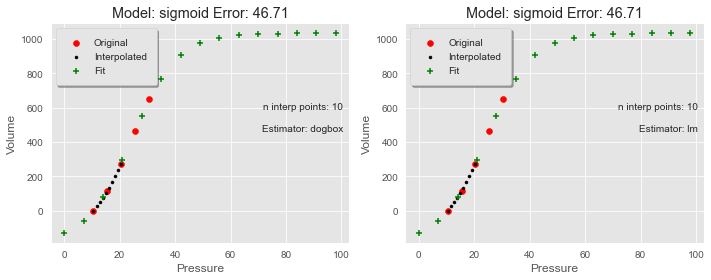

In [7]:
fitter.make_plot(df = injuried, n_best = 2)

### Find zero and exp (NAO INTERPOLADO)

In [10]:
def select_best(df:pd.DataFrame):
    best_fit = df.sort_values(by = "error").reset_index().iloc[0]

    a = best_fit["param"][0]
    b = best_fit["param"][1]
    best_fit_func = best_fit["function"]
    
    return best_fit["param"], best_fit_func


def find_zero(offSet:float, best_fit_func, params:np.ndarray, pressure:int, learning_rate=0.01):

    volume=0
    
    while(True):
        if offSet < volume:
            volume = best_fit_func(pressure, *params)
            pressure-=learning_rate
        else:
            break
            
    return np.array([pressure,volume])

def exponential_cicle(x, a, b, c):
    return -a*np.exp(-b*x)+c


def find_best_b(df:pd.DataFrame, raw_pressures:np.ndarray,b_percentage_range:tuple=(0.05,0.125), step:float=0.001, plot_figure:bool=True):

    params, best_fit_func = select_best(df)

    a = params[0]
    b = params[1]

    b_var_lst = []
    b_percentage_lst = []
    guess_zero_lst = []

    b_initial, b_end = b_percentage_range

    for b_percentage in np.arange(b_initial, b_end, 0.001):

        offSet = (b_percentage*b+a)
        initial_pressure = raw_pressures[0,0]

        guess_zero = find_zero(offSet, best_fit_func, params, initial_pressure, learning_rate = 0.01)
        guess_zero_lst.append(guess_zero)
        
        try:
            """
            ESTOU IGNORANDO O PRIMEIRO PAR DE PONTOS, POIS COMECA NO 4 ESSE ARRAY
            """
            b_exp_run_lst = []

            for i in range(4, len(raw_pressures)+1, 2):
                #Select first two points
                run = raw_pressures[i-2:i,:]
                #Add guess_zero
                run = np.vstack([guess_zero,run])
                #Fit curve with 3 points
                parameters, pcov = curve_fit(exponential_cicle, run[:,0], run[:,1], method="lm")
                b_exp_run_lst.append(parameters[1])

            b_var_lst.append(np.var(b_exp_run_lst))
            b_percentage_lst.append(b_percentage)
            b_exp_run_lst = []

        except Exception as e:
            print(e)
            
    if plot_figure:
        data=pd.DataFrame([b_percentage_lst,b_var_lst]).T.rename(columns = {0:"b_percentage", 1:"b_var"}).astype(float)
        
        fig = plt.figure(figsize = (8,6))
        ax = sns.scatterplot(x="b_percentage", y="b_var", data=data)
        plt.tight_layout()
        plt.show()
        
    index_best_b = np.argmin(b_var_lst)
    return b_percentage_lst[index_best_b], guess_zero_lst[index_best_b]

Best b: 0.08600000000000003
Best zero: [  5.02618474 -83.67586325]


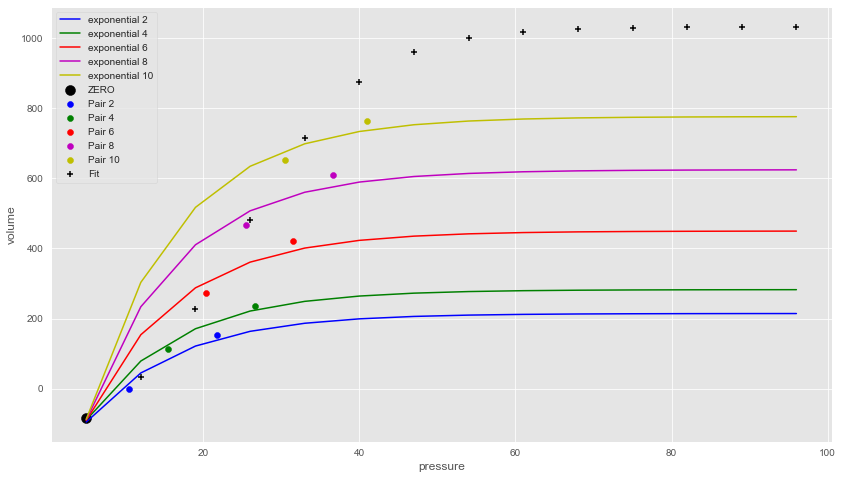

In [28]:
best_b, guess_zero = find_best_b(injuried, raw_pressures=d_data,  b_percentage_range=(0.05,0.125), step=0.001, plot_figure=False)

def exponential_cicle_fixed_b(x, a, c):
    return -a*np.exp(-best_b*x)+c

######################################################################################################
plt.figure(figsize = (14,8))
plt.scatter(guess_zero[0],guess_zero[1], c = 'k', s = 100, label = "ZERO")

new_pressures = range(int(guess_zero[0]), 100, 7)

colors = ["b","g","r","m","y"]

for i, cor in zip(range(2, d_data.shape[0]+1, 2), colors):
    
    run = d_data[i-2:i,:]
    run = np.vstack([guess_zero,run])

    parameters, pcov = curve_fit(exponential_cicle_fixed_b, run[:,0], run[:,1], method="lm")

    new_volumes = exponential_cicle_fixed_b(new_pressures, *parameters)
    plt.plot(new_pressures, new_volumes, c=cor, label = f"exponential {i}")
    plt.scatter(d_data[i-2:i,0], d_data[i-2:i,1], c=cor, label = f"Pair {i}")
    ##

##Plotando best fit
best_fit = injuried.sort_values(by = "error").reset_index().iloc[0]
new_volumes = best_fit["function"](new_pressures,*best_fit["param"])
plt.scatter(new_pressures,new_volumes, c = 'black', marker = '+', label = "Fit")

plt.xlabel("pressure")
plt.ylabel("volume")
print(f"Best b: {best_b}")
print(f"Best zero: {guess_zero}")
plt.legend()
plt.show()

### Healthy

In [ ]:
#Interpolando
fitter = funcFitter(s_data[0::2, :], n_point = 3, estimators = estimators)
healthy = fitter.fit(funcs=funcs, interpolate=True, n_interp_point=10, interp_method="linear")

In [ ]:
fitter.make_plot(df = healthy, n_best = 5)